<p><font size="6"><b> Raster operations and raster-vector tools</b></font></p>


> *DS Python for GIS and Geoscience*  
> *October, 2021*
>
> *© 2021, Joris Van den Bossche and Stijn Van Hoey. Licensed under [CC BY 4.0 Creative Commons](http://creativecommons.org/licenses/by/4.0/)*

---

In the previous notebooks, we focused either on vector data or raster data. Often you encounter both types of data and want to combine them. In this notebook, we show *some* examples of typical raster/vector interactions.

In [2]:
import pandas as pd
import numpy as np
import geopandas
import rasterio

import xarray as xr

import matplotlib.pyplot as plt

# `rioxarray`: xarray extension based on rasterio

In the previous notebooks, we already used `rasterio` (https://rasterio.readthedocs.io/en/latest/) to read raster files such as GeoTIFFs (through the `xarray.open_rasterio()` function). Rasterio provides support for reading and writing geospatial raster data as numpy N-D arrays, mainly through bindings to the GDAL library. 

In addition, rasterio provides a Python API to perform some GIS raster operations (clip, mask, warp, merge, transformation,...) and can be used to only load a subset of a large dataset into memory. However, the main complexity in using `rasterio`, is that the spatial information is decoupled from the data itself (i.e. the numpy array). This means that you need to keep track and organize the extent and metadata throughout the operations (e.g. the "transform") and you need to keep track of what each dimension represents (y-first, as arrays are organized along rows first). Notebook [91_package_rasterio](./91_package_rasterio.ipynb) goes into more depth on the rasterio package itself. 

Enter `rioxarray` (https://corteva.github.io/rioxarray/stable/index.html), which extends xarray with geospatial functionalities powered by rasterio.

In [3]:
import rioxarray

In [4]:
data_file = "./data/herstappe/raster/2020-09-17_Sentinel_2_L1C_True_color.tiff"

In [5]:
data = rioxarray.open_rasterio(data_file)
data

<xarray.DataArray (band: 3, y: 227, x: 447)>
[304407 values with dtype=float32]
Coordinates:
  * band         (band) int64 1 2 3
  * x            (x) float64 5.935e+05 5.935e+05 ... 6.113e+05 6.114e+05
  * y            (y) float64 6.578e+06 6.577e+06 ... 6.569e+06 6.568e+06
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0

The `rioxarray.open_rasterio` function is similar to `xarray.open_rasterio`, but in addition adds a `spatial_ref` coordinate to keep track of the spatial reference information.

Once `rioxarray` is imported, it provides a `.rio` accessor on the xarray.DataArray object, which gives access to some properties of the raster data:

In [6]:
data.rio.crs

CRS.from_epsg(3857)

In [7]:
data.rio.bounds()

(593476.1968631798, 6568444.042372982, 611391.1253675179, 6577549.60336745)

In [8]:
data.rio.resolution()

(40.07813983073409, -40.1126034998577)

In [9]:
data.rio.nodata

In [10]:
data.rio.transform()

Affine(40.07813983073409, 0.0, 593476.1968631798,
       0.0, -40.1126034998577, 6577549.60336745)

## Reprojecting rasters

`rioxarray` gives access to a set of raster processing functions from rasterio/GDAL. 

One of those is to reproject (transform and resample) rasters, for example to reproject to different coordinate reference system, up/downsample to a different resolution, etc. In all those case, in the transformation of a source raster to a destination raster, pixel values need to be recalculated. There are different "resampling" methods this can be done: taking the nearest pixel value, calculating the average, a (non-)linear interpolation, etc.

The functionality is available through the `reproject()` method. Let's start with reprojecting the Herstappe tiff to a different CRS:

In [12]:
data.rio.crs

CRS.from_epsg(3857)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


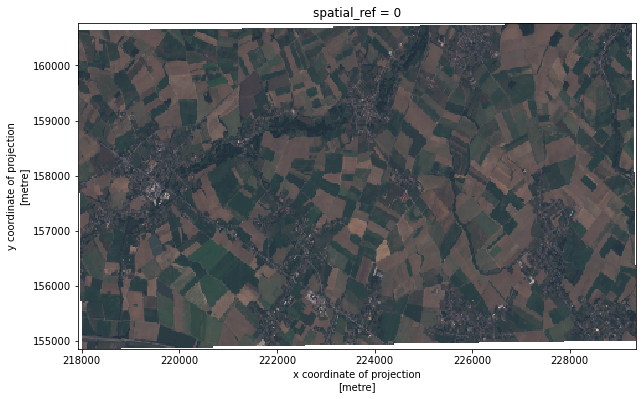

In [13]:
data.rio.reproject("EPSG:31370").plot.imshow(figsize=(10,6))

The default resampling method is "nearest", which is often not a suitable method (especially for continuous data). We can change the method using the `rasterio.enums.Resampling` enumeration (see [docs](https://rasterio.readthedocs.io/en/latest/api/rasterio.enums.html#rasterio.enums.Resampling) for a overview of all methods):

In [14]:
from rasterio.enums import Resampling

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


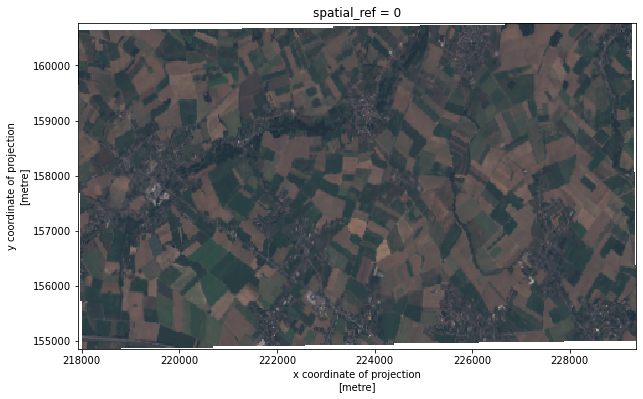

In [15]:
data.rio.reproject("EPSG:31370", resampling=Resampling.bilinear).plot.imshow(figsize=(10,6))

The method can also be used to downsample at the same time:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


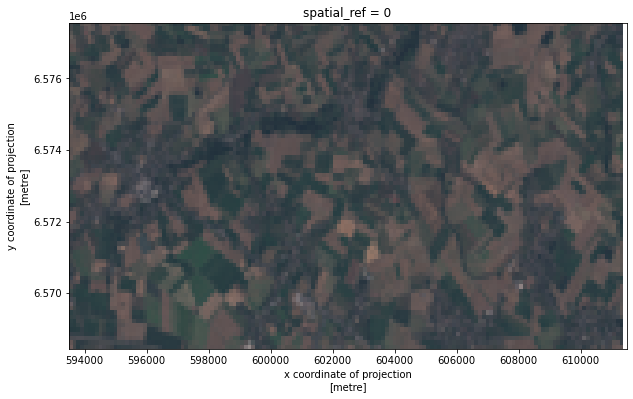

In [17]:
data.rio.reproject(data.rio.crs, resolution=120, resampling=Resampling.cubic).plot.imshow(figsize=(10,6))

## Extract the data you need

In many applications, a specific research area is used. Extracting the data you need from a given raster data set by a vector (polygon) file is a common operation in GIS analysis. We use the clipping example to explain the typical workflow with rioxarray / rasterio.

For our Herstappe example, the study area is available as vector data `./data/herstappe/vector/herstappe.geojson`:

In [18]:
herstappe_vect = geopandas.read_file("./data/herstappe/vector/herstappe.geojson")
herstappe_vect

gml_id   UIDN  OIDN  TERRID NISCODE       NAAM   DATPUBLBS NUMAC  \
0  Refgem.202  642.0  37.0    59.0   73028  Herstappe  1831-02-07         

                                            geometry  
0  MULTIPOLYGON (((5.41544 50.72148, 5.41568 50.7...

<AxesSubplot:>

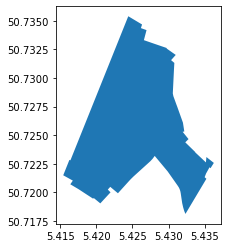

In [19]:
herstappe_vect.plot()

In [20]:
herstappe_vect.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Make sure both data sets are defined in the same CRS and extracting the geometry can be used as input for the masking:

In [22]:
herstappe_vect = herstappe_vect.to_crs(epsg=3857)

In [23]:
clipped = data.rio.clip(herstappe_vect.geometry)

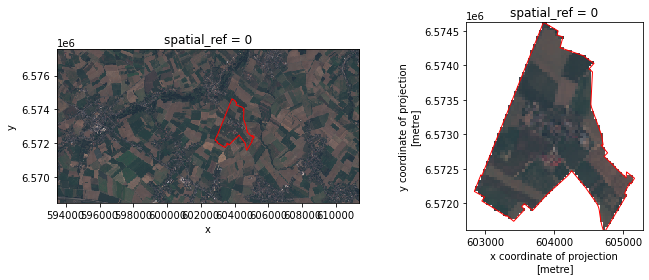

In [29]:
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(10,4))
data.plot.imshow(ax=ax0)
herstappe_vect.plot(ax=ax0, facecolor="none", edgecolor="red")

clipped.plot.imshow(ax=ax1)
herstappe_vect.plot(ax=ax1, facecolor="none", edgecolor="red")

fig.tight_layout()

The above uses the `rasterio` package (with the `mask` and `geometry_mask` / `rasterize` functionality) under the hood. This simplifies the operation compared to directly using `rasterio`.


```python
# cfr. The Rasterio workflow

from rasterio.mask import mask

# 1 - Open a data set using the context manager
with rasterio.open(data_file) as src: 

    # 2 - Read and transform the data set by clipping
    out_image, out_transform = mask(src, herstappe_vect.geometry, crop=True)
    
    # 3 - Update the spatial metadata/profile of the data set
    herstappe_profile = src.profile
    herstappe_profile.update({"height": out_image.shape[1],
                              "width": out_image.shape[2],
                              "transform": out_transform})
    # 4 - Save the new data set with the updated metadata/profile                   
    with rasterio.open("./herstappe_masked.tiff", "w", **herstappe_profile) as dest: 
        dest.write(out_image)
```

The [91_package_rasterio](./91_package_rasterio.ipynb) notebook explains this workflow in more detail.

One important difference, though, is that the above `rasterio` workflow will not load the full raster into memory when only loading (clipping) a small part of it. This can also be achieved in `rioxarray` with the `from_disk` keyword.

## Convert vector to raster

### Load DEM raster and river vector data

As example, we are using data from the Zwalm river area in Flanders. 

The digital elevation model (DEM) can be downloaded via the [governmental website](https://download.vlaanderen.be/Producten/Detail?id=936&title=Digitaal_Hoogtemodel_Vlaanderen_II_DSM_raster_5_m) ([download link](https://downloadagiv.blob.core.windows.net/dhm-vlaanderen-ii-dsm-raster-5m/DHMVIIDSMRAS5m_k30.zip), extracted in the `/data` directory for this example)/

In [30]:
dem_zwalm_file = "data/DHMVIIDSMRAS5m_k30/GeoTIFF/DHMVIIDSMRAS5m_k30.tif"

_Make sure you have downloaded the data set ([download link](https://downloadagiv.blob.core.windows.net/dhm-vlaanderen-ii-dsm-raster-5m/DHMVIIDSMRAS5m_k30.zip)), saved it in the `./data` subfolder and unzipped the folder_

In [32]:
dem_zwalm = xr.open_rasterio(dem_zwalm_file).sel(band=1)

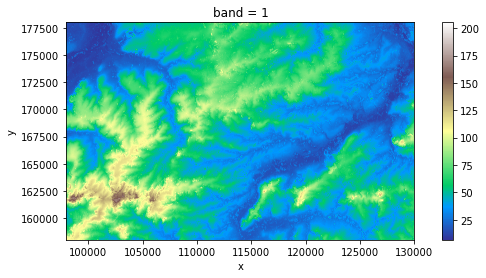

In [33]:
img = dem_zwalm.plot.imshow(
    cmap="terrain", figsize=(10, 4), interpolation='antialiased')
img.axes.set_aspect("equal")

Next, we download the shapes of the rivers in the area through a WFS (Web Feature Service):

In [34]:
import json
import requests

wfs_rivers = "https://geoservices.informatievlaanderen.be/overdrachtdiensten/VHAWaterlopen/wfs"
params = dict(service='WFS', version='1.1.0', request='GetFeature',
              typeName='VHAWaterlopen:Wlas', outputFormat='json',
              cql_filter="(VHAZONENR=460)OR(VHAZONENR=461)", srs="31370")

# Fetch data from WFS using requests
r = requests.get(wfs_rivers, params=params)

__Note__: A WFS is a standardized way to share vector GIS data sets on the internet, typically also used by web application, see ['A bit more about WFS'](#a_bit_more_about_WFS) section for more info.

And convert the output of the wfs call to a GeoDataFrame:

In [36]:
# Create GeoDataFrame from geojson
segments = geopandas.GeoDataFrame.from_features(json.loads(r.content), crs="epsg:31370")

In [37]:
segments.head()

geometry    UIDN    OIDN     VHAS  \
0  LINESTRING (110776.097 175615.174, 110712.279 ...  663973  123742  4521065   
1  LINESTRING (110909.320 175766.345, 110909.145 ...  664217  124659  4521522   
2  LINESTRING (106420.500 168176.000, 106416.297 ...  664420  103285  1999001   
3  LINESTRING (110445.569 176389.209, 110446.273 ...  664575  123828  4521442   
4  LINESTRING (105378.499 166313.038, 105379.830 ...  664667  103287  1999006   

   VHAG               NAAM REGCODE REGCODE1    BEHEER  CATC  \
0  5026          Molenbeek   OS277              40000     2   
1  5026          Molenbeek   OS277              40000     2   
2  5360          Dorenbeek                   ONBEKEND     9   
3  5057          Steenbeek   OS280              40000     2   
4  5134  Slijpkotmolenbeek                   ONBEKEND     9   

                         LBLCATC  BEKNR              BEKNAAM  STRMGEB  GEO  \
0  Geklasseerd, tweede categorie      6  Boven-Scheldebekken  Schelde    0   
1  Geklasseerd, tweede categorie      6  Boven-Scheldebekken  Schelde    0   
2               Niet geklasseerd      6  Boven-Scheldebekken  Schelde    0   
3  Geklasseerd, tweede categorie      6  Boven-Scheldebekken  Schelde    0   
4               Niet geklasseerd      6  Boven-Scheldebekken  Schelde    0   

         LBLGEO VHAZONENR WTRLICHC  
0  10 tot 2.5 m       461      994  
1  10 tot 2.5 m       461      994  
2  10 tot 2.5 m       460    11000  
3  10 tot 2.5 m       461      994  
4  10 tot 2.5 m       460    11000

<AxesSubplot:>

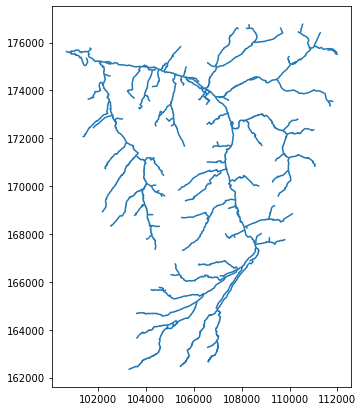

In [38]:
segments.plot(figsize=(8, 7))

### Clip raster with vector

The catchment extent is much smaller than the DEM file, so clipping the data first will make the computation less heavy.

Let's first download the catchment area of the Zwalm river from the Flemish government (using WFS again):

In [40]:
import json
import requests

wfs_bekkens = "https://geoservices.informatievlaanderen.be/overdrachtdiensten/Watersystemen/wfs"
params = dict(service='WFS', version='1.1.0', request='GetFeature',
              typeName='Watersystemen:WsDeelbek', outputFormat='json',
              cql_filter="DEELBEKNM='Zwalm'", srs="31370")

# Fetch data from WFS using requests
r = requests.get(wfs_bekkens, params=params)
catchment = geopandas.GeoDataFrame.from_features(json.loads(r.content), crs="epsg:31370")

In [41]:
catchment

geometry  OIDN  UIDN DEELBID  \
0  MULTIPOLYGON (((112222.397 176907.296, 112178....   165   264   06-05   

  DEELBEKNM  
0     Zwalm

Save to a file for later reuse:

In [42]:
# save to file
catchment = catchment.to_crs('epsg:4326') # geojson is default 4326
catchment.to_file("./data/zwalmbekken.geojson", driver="GeoJSON")

<AxesSubplot:>

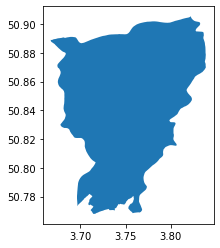

In [43]:
geopandas.read_file("./data/zwalmbekken.geojson").plot()

#### 1. Using rioxarray (rasterio)

As shown above, we can use rioxarray to clip the raster file:

In [44]:
dem_zwalm = xr.open_rasterio(dem_zwalm_file).sel(band=1)
dem_zwalm

<xarray.DataArray (y: 4000, x: 6400)>
[25600000 values with dtype=float32]
Coordinates:
    band     int64 1
  * y        (y) float64 1.78e+05 1.78e+05 1.78e+05 ... 1.58e+05 1.58e+05
  * x        (x) float64 9.8e+04 9.801e+04 9.801e+04 ... 1.3e+05 1.3e+05 1.3e+05
Attributes:
    transform:      (5.0, 0.0, 98000.0, 0.0, -5.0, 178000.0)
    crs:            +init=epsg:31370
    res:            (5.0, 5.0)
    is_tiled:       1
    nodatavals:     (-9999.0,)
    scales:         (1.0,)
    offsets:        (0.0,)
    AREA_OR_POINT:  Area
    VERTICAL_SRS:   EPSG:5110

In [46]:
clipped = dem_zwalm.rio.clip(catchment.to_crs('epsg:31370').geometry)

Using rioxarray's `to_raster()` method, we can also save the result to a new GeoTIFF file:

In [47]:
clipped.rio.to_raster("./dem_masked_rio.tiff")

This DEM raster file used -9999 as the NODATA value, and this is therefore also used for the clipped result:

In [48]:
clipped.rio.nodata

-9999.0

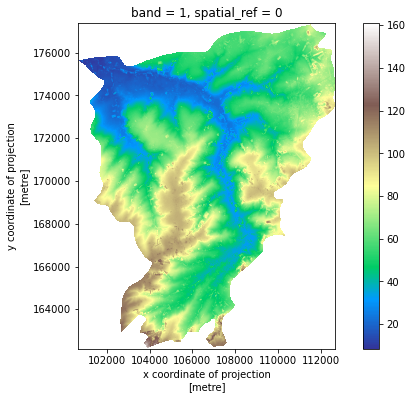

In [49]:
img = clipped.where(clipped != -9999).plot.imshow(
    cmap='terrain', figsize=(10, 6), interpolation='antialiased')
img.axes.set_aspect("equal")

With rioxarray, we can also convert nodata values to NaNs (and thus using float dtype) when loading the raster data:

In [50]:
dem_zwalm2 = rioxarray.open_rasterio(dem_zwalm_file, masked=True).sel(band=1)

In [51]:
dem_zwalm2.rio.nodata

nan

In [52]:
dem_zwalm2.rio.clip(catchment.to_crs('epsg:31370').geometry)

<xarray.DataArray (y: 3050, x: 2405)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * y            (y) float64 1.774e+05 1.774e+05 ... 1.621e+05 1.621e+05
  * x            (x) float64 1.007e+05 1.007e+05 ... 1.127e+05 1.127e+05
    band         int64 1
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0

If we want to avoid loading the full original raster data, the `from_disk` keyword can be used.

In [53]:
dem_zwalm2.rio.clip(catchment.to_crs('epsg:31370').geometry, from_disk=True)

<xarray.DataArray (y: 3050, x: 2405)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * y            (y) float64 1.774e+05 1.774e+05 ... 1.621e+05 1.621e+05
  * x            (x) float64 1.007e+05 1.007e+05 ... 1.127e+05 1.127e+05
    band         int64 1
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0

#### 2. Using GDAL CLI

If we have the raster and vector files on disk, [`gdal CLI`](https://gdal.org/programs/index.html) will be very fast to work with (note that GDAL automatically handles the CRS difference of the raster and vector).

In [ ]:
rm ./dem_masked_gdal.tiff

In [56]:
!gdalwarp -cutline ./data/zwalmbekken.geojson -crop_to_cutline data/DHMVIIDSMRAS5m_k30/GeoTIFF/DHMVIIDSMRAS5m_k30.tif ./dem_masked_gdal.tiff

Creating output file that is 2403P x 3049L.
Processing data/DHMVIIDSMRAS5m_k30/GeoTIFF/DHMVIIDSMRAS5m_k30.tif [1/1] : 0Using internal nodata values (e.g. -9999) for image data/DHMVIIDSMRAS5m_k30/GeoTIFF/DHMVIIDSMRAS5m_k30.tif.
Copying nodata values from source data/DHMVIIDSMRAS5m_k30/GeoTIFF/DHMVIIDSMRAS5m_k30.tif to destination ./dem_masked_gdal.tiff.
...10...20...30...40...50...60...70...80...90...100 - done.


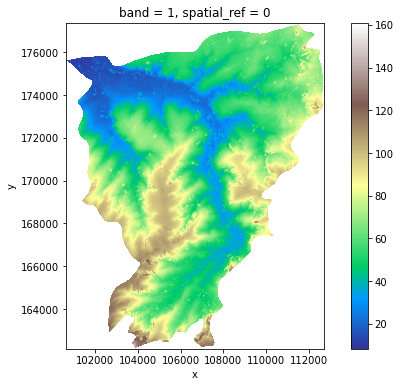

In [57]:
clipped_gdal = rioxarray.open_rasterio("./dem_masked_gdal.tiff", masked=True).sel(band=1)
img = clipped_gdal.plot.imshow(
    cmap="terrain", figsize=(10, 6), interpolation='antialiased')
img.axes.set_aspect("equal")

<div class="alert alert-info" style="font-size:120%">

**TIP**: <br>
    
In the GIS world, also other libraries do provide a large set of functionalities as command line instructions with a `FILE IN` -> `RUN COMMAND` -> `FILE OUT` approach, with some of them providing a Python interface as well. Some important once are:
    
- The [`gdal` library](https://gdal.org/programs/index.html#raster-programs) is the open source Swiss Army knife for raster and vector geospatial data handling. 
- The [SAGA GIS](http://www.saga-gis.org/en/index.html) has a [huge set](http://www.saga-gis.org/saga_tool_doc/8.0.0/a2z.html) of CLI commands, going from flow accumulation to classification algorithms.
- The [WhiteboxTools](https://www.whiteboxgeo.com/geospatial-software/) is another example of a library with a lot of functionalities, e.g. hydrological, agricultural and terrain analysis tools.
    
Other important initiatives like [Grass](https://grasswiki.osgeo.org/wiki/GRASS-Wiki) and [PCRaster](https://pcraster.geo.uu.nl/) are worthwhile to check out. Most of these libraries of tools can also be used with QGIS.
    
__NOTE:__ You can run a CLI command inside a Jupyter Notebook by prefixing it with the `!` character.

</div>

## Convert vector to raster

To create a raster with the vector "burned in", we can use the `rasterio.features.rasterize` function. This expects a list of (shape, value) tuples, and an output image shape and transform. Here, we will create a new raster image with the same shape and extent as the DEM above. And we first take a buffer of the river lines:

In [58]:
import rasterio.features

In [59]:
segments_buffered = segments.geometry.buffer(100)
img = rasterio.features.rasterize(
    segments_buffered, 
    out_shape=clipped.shape, 
    transform=clipped.rio.transform())

In [60]:
img

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

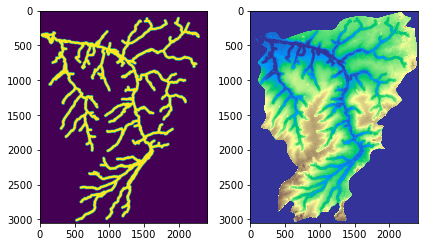

In [63]:
fig, (ax0, ax1) = plt.subplots(1, 2)
ax0.imshow(img*50)
ax1.imshow(clipped.values - img*20, vmin=0, cmap="terrain") # just as an example
fig.tight_layout()

## Let's practice!

For these exercises, a set of raster and vector datasets for the region of Ghent is available. Throughout the exercises, the goal is to map preferential locations to live given a set of conditions (certain level above sea-level, quiet and green neighbourhood, ..).

We start with the Digital Elevation Model (DEM) for Flanders. The data is available at https://overheid.vlaanderen.be/informatie-vlaanderen/producten-diensten/digitaal-hoogtemodel-dhmv, We downloaded the 25m resolution raster image, and provided a subset of this dataset as a zipped Tiff file in the course material.

<div class="alert alert-success">

**EXERCISE**:

* Read the DEM using `rioxarray`. The zip file is available at `data/gent/DHMVIIDTMRAS25m.zip"`. You can either unzip the file, and use the path to the unzipped file, or prepend `zip://` to the path. 
* What is the CRS of this dataset?
* The dataset has a third dimension with a single band. This doesn't work for plotting, so create a new `DataArray` by selecting the single band. Assign the result to a variable `dem`.
* Make a quick plot of the dataset.

<details><summary>Hints</summary>

* Rasterio can directly read from a zip-file. If one wants read the file `./data/gent/FILENAME.zip`, add the `zip://.data/gent/FILENAME.zip` to read the zip file directly.
* The `crs` is an attribute, not a function, so no `()` required.
* Selecting in xarray is done with `sel`
* We will improve the plot in the following exercises, but as a quick solution, we already learnt about the `robust=True` plot option of xarray. 
* Just pick a color map that you like.

</details>   
    
</div>

In [77]:
dem = rioxarray.open_rasterio("zip://./data/gent/DHMVIIDTMRAS25m.zip")
dem

<xarray.DataArray (band: 1, y: 1480, x: 1520)>
[2249600 values with dtype=float32]
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 8.701e+04 8.704e+04 8.706e+04 ... 1.25e+05 1.25e+05
  * y            (y) float64 2.2e+05 2.2e+05 2.199e+05 ... 1.83e+05 1.83e+05
    spatial_ref  int64 0
Attributes:
    _FillValue:    -9999.0
    scale_factor:  1.0
    add_offset:    0.0

In [78]:
dem.rio.crs

CRS.from_epsg(31370)

In [79]:
dem = rioxarray.open_rasterio("zip://./data/gent/DHMVIIDTMRAS25m.zip").sel(band=1)
dem

<xarray.DataArray (y: 1480, x: 1520)>
[2249600 values with dtype=float32]
Coordinates:
    band         int64 1
  * x            (x) float64 8.701e+04 8.704e+04 8.706e+04 ... 1.25e+05 1.25e+05
  * y            (y) float64 2.2e+05 2.2e+05 2.199e+05 ... 1.83e+05 1.83e+05
    spatial_ref  int64 0
Attributes:
    _FillValue:    -9999.0
    scale_factor:  1.0
    add_offset:    0.0

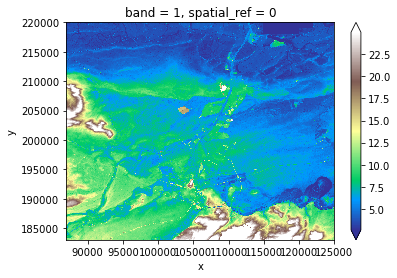

In [85]:
dem.plot.imshow(robust=True, cmap="terrain")

<div class="alert alert-success">

**EXERCISE**:

The dataset uses a large negative value to denote the "nodata" value (in this case meaning "outside of Flanders").
    
* Check the value that is used as "nodata" value.
* Repeat the plot from the previous exercise, but now set a fixed minimum value of 0 for the colorbar, to ignore the negative "nodata" in the color scheme.
* Replace the "nodata" value with `np.nan` using the `where()` method. 
    
<details><summary>Hints</summary>

* The `nodata` attribute is provided by the rioxarray package. Rioxarray loads this information from the geotiff file metadata and makes it available as `.rio.nodata`. 
* The `.rio.nodata` is a class attribute, not a function, so no `()` required.
* `vmin` and `vmax` define the colormap limits.
* `ẁhere` expects a condition (i.e. boolean values), e.g. `... != dem.rio.nodata`.
</details>   
    
</div>

In [101]:
dem.rio.nodata

-9999.0

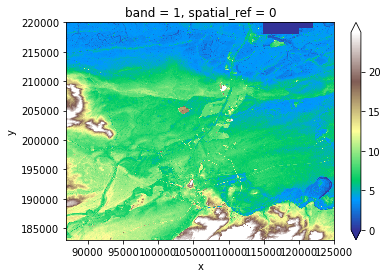

In [102]:
dem.plot.imshow(robust=True, vmin=0, cmap="terrain")

In [103]:
dem_masked = dem.where(dem != dem.rio.nodata)

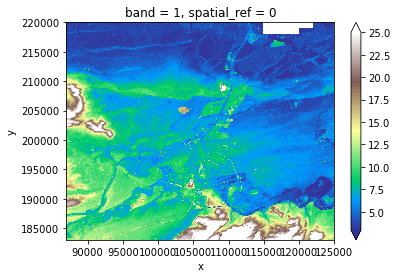

In [108]:
dem_masked.plot.imshow(robust=True, cmap="terrain")

Alternatively to masking the nodata value yourself, you can do this directly when loading the data as well, using the `masked=True` keyword of `open_rasterio()`:

In [107]:
dem_masked = rioxarray.open_rasterio("zip://./data/gent/DHMVIIDTMRAS25m.zip", masked=True).sel(band=1)

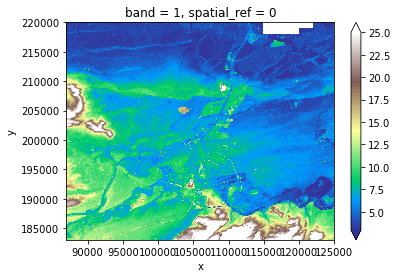

In [109]:
dem_masked.plot.imshow(robust=True, cmap="terrain")

<div class="alert alert-success">

**EXERCISE**:

We want to limit our search for locations to the surroundings of the centre of Ghent.

* Create a `Point` object for the centre of Ghent. Latitude/longitude coordinates for the Korenmarkt are: 51.05393, 3.72174
* We need our point in the same Coordinate Reference System as the DEM raster (i.e. EPSG:31370, or Belgian Lambert 72). Use GeoPandas to reproject the point:
    * Create a GeoSeries with this single point and specify its CRS with the `crs` keyword.
    * Reproject this series with the `to_crs` method. Assign the resulting GeoSeries to a variable `gent_centre_31370`.
* Calculcate a buffer of 10km radius around the point.
* Get the bounding box coordinates of this buffer. Assign this to `gent_bounds`.
    
<details><summary>Hints</summary>

* Remember the introduction on geospatial data and the shapely objects, e.g. `shapely.geometry.Point`?
* Use `geopandas.GeoSeries` to create a new GeoSeries and add the `crs` parameter. The lat/lon of the Kornmarkt are provided as EPSG:4326. 
* In EPSG:31370, the unit is meter, so make sure to use meter to define the buffer size.
* `.total_bounds` is a class attribute.

</details>   
    
</div>

In [118]:
from shapely.geometry import Point

In [119]:
gent_centre = Point(3.72174, 51.05393)

In [120]:
gent_centre_31370 = geopandas.GeoSeries([gent_centre], crs="EPSG:4326").to_crs("EPSG:31370")

In [121]:
gent_bounds = gent_centre_31370.buffer(10*1000).total_bounds
# or first extracting the Point again:
# gent_bounds = gent_centre_31370[0].buffer(10*1000).bounds
gent_bounds

array([ 94634.86315037, 183949.92234279, 114634.86315037, 203949.92234279])

<div class="alert alert-success">

**EXERCISE**:

With this bounding box, we can now clip a subset of the DEM raster for the area of interest. 
    
* Clip the `dem` raster layer. To clip with a bounding box instead of a geometry, you can use the `rio.clip_box()` method instead of `rio.clip()`.
* Make a plot. Use the "terrain" color map, and set the bounds of the color scale to 0 - 30.

<details><summary>Hints</summary>

* The `gent_bounds` is an array of 4 elements, whereas `clip_box` requires these as seperate input parameters... Did you know that in Python you can unpack these 4 values with the `*`: `*gent_bounds` will unpack to 4 individual input.

</details>   
    
</div>

In [124]:
dem_gent = dem.rio.clip_box(*gent_bounds)
dem_gent

<xarray.DataArray (y: 801, x: 801)>
array([[ 7.36,  7.26,  7.07, ...,  5.12,  5.09,  5.16],
       [ 7.27,  7.01,  6.99, ...,  5.11,  5.18,  5.34],
       [ 6.93,  6.96,  7.02, ...,  5.38,  5.18,  5.22],
       ...,
       [11.51, 11.5 , 11.51, ..., 21.43, 20.89, 20.35],
       [11.4 , 11.51, 11.5 , ..., 21.36, 20.88, 20.19],
       [11.4 , 10.82, 13.57, ..., 21.19, 20.87, 20.58]], dtype=float32)
Coordinates:
    band         int64 1
  * x            (x) float64 9.464e+04 9.466e+04 ... 1.146e+05 1.146e+05
  * y            (y) float64 2.039e+05 2.039e+05 ... 1.84e+05 1.839e+05
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0
    _FillValue:    -9999.0

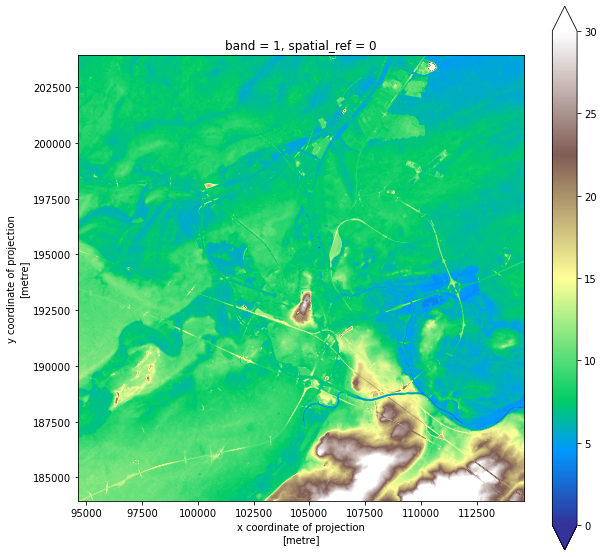

In [125]:
img = dem_gent.plot.imshow(
    cmap="terrain", figsize=(10, 10), interpolation='antialiased', vmin=0, vmax=30)
img.axes.set_aspect("equal")

The CORINE Land Cover (https://land.copernicus.eu/pan-european/corine-land-cover) is a program by the European Environment Agency (EEA) to provide an inventory of land cover in 44 classes of the European Union. The data is provided in both raster as vector format and with a resolution of 100m.

The data for the whole of Europe can be downloaded from the website (latest version: https://land.copernicus.eu/pan-european/corine-land-cover/clc2018?tab=download). This is however a large dataset, so we downloaded the raster file and cropped it to cover Flanders, and this subset is included in the repo as `data/CLC2018_V2020_20u1_flanders.tif` (the code to do this cropping can be see at [data/preprocess_data.ipynb#CORINE-Land-Cover](data/preprocess_data.ipynb#CORINE-Land-Cover)).

<div class="alert alert-success">

**EXERCISE**:

* Read the land use data provided as a tif (`data/CLC2018_V2020_20u1_flanders.tif`). 
* Make a quick plot. The raster is using a negative value as "nodata", consider using the `robust=True` option.
* What is the resolution of this raster?
* What is the CRS?

<details><summary>Hints</summary>

* `rio.resolution()` is a method, so it requires the `()`.
* `rio.crs` is an attribute, so it does not require the `()`.

</details>   
    
</div>

In [133]:
land_use = rioxarray.open_rasterio("data/CLC2018_V2020_20u1_flanders.tif").sel(band=1)
land_use

<xarray.DataArray (y: 1133, x: 2530)>
[2866490 values with dtype=int8]
Coordinates:
    band         int64 1
  * x            (x) float64 3.79e+06 3.79e+06 3.79e+06 ... 4.042e+06 4.042e+06
  * y            (y) float64 3.178e+06 3.178e+06 ... 3.065e+06 3.065e+06
    spatial_ref  int64 0
Attributes:
    _FillValue:    -128.0
    scale_factor:  1.0
    add_offset:    0.0

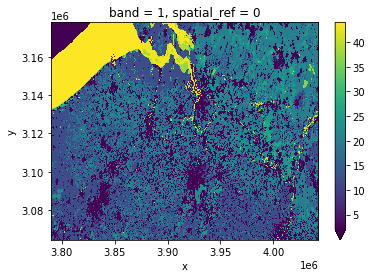

In [134]:
land_use.plot.imshow(robust=True)

In [135]:
land_use.rio.resolution()

(100.0, -100.0)

In [136]:
land_use.rio.crs

CRS.from_epsg(3035)

<div class="alert alert-success">

**EXERCISE**:

The land use dataset is a European dataset and uses a Europe-wide projected CRS (https://epsg.io/3035).

* Reproject the land use raster to the same CRS as the DEM raster (EPSG:31370), and plot the result.

<details><summary>Hints</summary>

* For the sake of the exercise, pick any resampling algorithm or just the default option.

</details>   
    
</div>

In [137]:
land_use_reprojected = land_use.rio.reproject(dem_gent.rio.crs)
land_use_reprojected

<xarray.DataArray (y: 1210, x: 2494)>
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int8)
Coordinates:
  * x            (x) float64 1.526e+04 1.536e+04 ... 2.696e+05 2.697e+05
  * y            (y) float64 2.515e+05 2.514e+05 ... 1.282e+05 1.281e+05
    band         int64 1
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0
    _FillValue:    -128

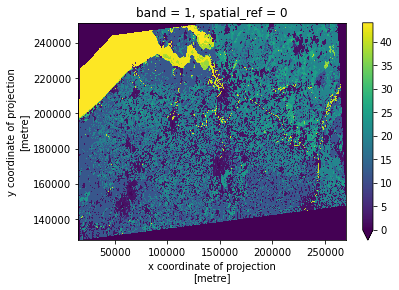

In [139]:
land_use_reprojected.plot.imshow(robust=True)

<div class="alert alert-success">

**EXERCISE**:

In addition to reprojecting to a new CRS, we also want to upsample the land use dataset to the same resolution as the DEM raster, and to use the exact same grid layout, so we can compare and combine those rasters pixel-by-pixel.

Such a reprojection can be done with the `reproject()` method by providing the target geospatial "transform" (which has the information for the bounds and resolution) and shape for the result. `rioxarray` provides a short-cut for this operation with the `reproject_match()` method, to reproject one raster to the CRS, extent and resolution of another raster.  

* Reproject the land use raster to the same CRS and extent as the DEM subset for Ghent (`dem_gent`). Call the result `land_use_gent`.
* Make a plot of the result.

<details><summary>Hints</summary>

* Check the help of the `.rio.reproject_match` method (SHIFT + TAB) to know which input ou need. For the sake of the exercise, pick any resampling algorithm or just the default (nearest) option.
* The data calling the method is being transformed, and the input parameter is the target to match.

</details>   
    
</div>

In [144]:
land_use_gent = land_use.rio.reproject_match(dem_gent)

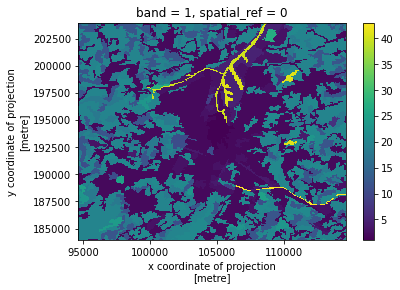

In [145]:
land_use_gent.plot.imshow()

The land use dataset is a raster with discrete values (i.e. different land use classes). The [CurieuzeNeuzen case study](case-curieuzeneuzen-air-quality.ipynb#Combining-with-Land-Use-data) goes into more depth on those values, but for this exercise it is sufficient to know that values 1 and 2 are the Continuous and Discontinuous urban fabric (residential areas).

<div class="alert alert-success">

**EXERCISE**:

Let's find the preferential locations to live, assuming we want to be future-proof and live at least 10m above sea level in a residential area.

* Create a new array denoting the residential areas (where `land_use_gent` is equal to 1 or 2). Call this `land_use_residential`, and make a quick plot.
* Plot those locations that are 10m above sea-level.
* Combine the residential areas and areas > 10m in a single array called `suitable_locations`, and plot the result.
    
<details><summary>Hints</summary>

* To select for multiple options, one can either combine multiple conditions using `|` (or) or us the `isin([...,...])` option, both will do.
* The output of a condition is a Boolean map that can be plot just like other maps, e.g. `(dem_gent > 10).plot.imshow()`.
* Fo the `suitable_locations`, both boolean conditions need to be True, so combine them with either `&` or just multiply them with `*`.

</details>   
    
</div>

In [166]:
land_use_residential = (land_use_gent == 1) | (land_use_gent == 2)
land_use_residential

<xarray.DataArray (y: 801, x: 801)>
array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])
Coordinates:
  * x            (x) float64 9.464e+04 9.466e+04 ... 1.146e+05 1.146e+05
  * y            (y) float64 2.039e+05 2.039e+05 ... 1.84e+05 1.839e+05
    band         int64 1
    spatial_ref  int64 0

In [167]:
# Alternative solution using `isin`
land_use_residential = land_use_gent.isin([1, 2])
land_use_residential

<xarray.DataArray (y: 801, x: 801)>
array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])
Coordinates:
  * x            (x) float64 9.464e+04 9.466e+04 ... 1.146e+05 1.146e+05
  * y            (y) float64 2.039e+05 2.039e+05 ... 1.84e+05 1.839e+05
    band         int64 1
    spatial_ref  int64 0

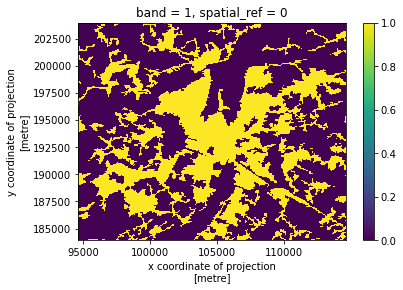

In [168]:
land_use_residential.plot.imshow()

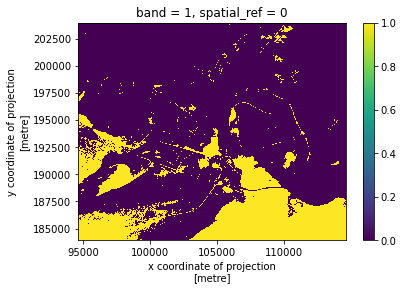

In [169]:
(dem_gent > 10).plot.imshow()

In [170]:
suitable_locations = land_use_residential * (dem_gent > 10)

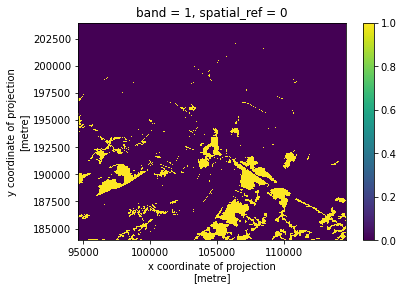

In [171]:
suitable_locations.plot.imshow()

<div class="alert alert-success">

**EXERCISE**:

In addition to the previous conditions, assume we also don't want to live close to major roads.

We downloaded the road segments open data from Ghent (https://data.stad.gent/explore/dataset/wegsegmenten-gent/) as a GeoJSON file, and provided this in the course materials: `/data/gent/vector/wegsegmenten-gent.geojson.zip`
    
* Read the GeoJSON road segments file into a variable `roads` and check the first few rows.
* The column "frc_omschrijving" contains a description of the type of road for each segment. Get an overview of the available segments and types by doing a "value counts" of this column.

<details><summary>Hints</summary>

* GeoPandas does NOT need the `zip://...` to read in zip files.
* The first few rows are also the `head` of a data set.
* The `value_counts` provides the number of records for each of the different values in a column.

</details>   
    
</div>

In [176]:
roads = geopandas.read_file("./data/gent/vector/wegsegmenten-gent.geojson.zip")

In [177]:
roads.head()

aanlegjaar_getal    wegsegid rrcode_rechts rrcode_links  objectid    p  \
0            1950.0  WEGO008289      90403828     90403828   2261985  0.0   
1            1950.0  WEGO004167      90009566     90009566   2261998  3.0   
2            1950.0  WEGO009958      90322123     90322123   2261999  0.0   
3            1950.0  WEGO005831      90000231     90000231   2262000  0.0   
4            1950.0  WEGO015568      90008150     90008150   2262002  NaN   

  pcode_rechts    o crabcode                frc_omschrijving  ...  aanlegjaar  \
0         9040  0.0    70636  Local Road of Minor Importance  ...        1950   
1         9000  0.0    71219                      Local Road  ...        1950   
2         9032  0.0    71947                      Local Road  ...        1950   
3         9000  0.0    70020                      Local Road  ...        1950   
4         9000  NaN   181670  Local Road of Minor Importance  ...        1950   

  functional_roadclass          straatnaam  eigenaar pcode_links  \
0                    7        Kasteelwegel        SG        9040   
1                    6  Ottergemsesteenweg        SG        9000   
2                    6       Vrouwenstraat        SG        9032   
3                    6           Elsstraat        SG        9000   
4                    7        Romeinse Hof        SG        9000   

                  aanmaakdat rr_type kenmerk routenr  \
0                       None    None    None    None   
1                       None    None    None    None   
2  2008-09-21T22:00:00+00:00    None    None    None   
3                       None    None    None    None   
4  2015-01-27T23:00:00+00:00    None    None    None   

                                            geometry  
0  LINESTRING (3.78413 51.06761, 3.78358 51.06778...  
1  LINESTRING (3.72974 51.03260, 3.73004 51.03216...  
2  LINESTRING (3.69149 51.08835, 3.69159 51.08825...  
3  LINESTRING (3.71244 51.06512, 3.71242 51.06515...  
4  LINESTRING (3.74828 51.07389, 3.74832 51.07388...  

[5 rows x 24 columns]

In [179]:
roads["frc_omschrijving"].value_counts()

Local Road of Minor Importance                 4717
Local Road                                     4323
Path                                           1789
Local Connecting Road                          1119
Other Major Road                                715
Local Road of High Importance                   664
Secondary Road                                  311
Other Road                                      208
a Major Road Less Important than a Motorway     185
Private roads                                   128
Motorway, Freeway, or Other Major Road          101
Name: frc_omschrijving, dtype: int64

<div class="alert alert-success">

**EXERCISE**:

We are interested in the big roads, as these are the ones we want to avoid: "Motorway or Freeway", "Major Road" and "Other Major Road".

* Filter the `roads` table based on the provided list of road types: select those rows where the "frc_omschrijving" column is equal to one of those values, and call this `roads_subset`.
* Make a quick plot of this subset and use the "frc_omschrijving" colum to color the lines.

<details><summary>Hints</summary>

* Selecting multiple options at the same time is most convenient with the `isin()` method.
* Use the GeoPandas `.plot` method and specifh the `frc_omschrijving` column to the `column` parameter.

</details>   
    
</div>

In [191]:
road_types = [
    "Motorway, Freeway, or Other Major Road",
    "a Major Road Less Important than a Motorway",
    "Other Major Road",
]

In [192]:
roads_subset = roads[roads["frc_omschrijving"].isin(road_types)]

<AxesSubplot:>

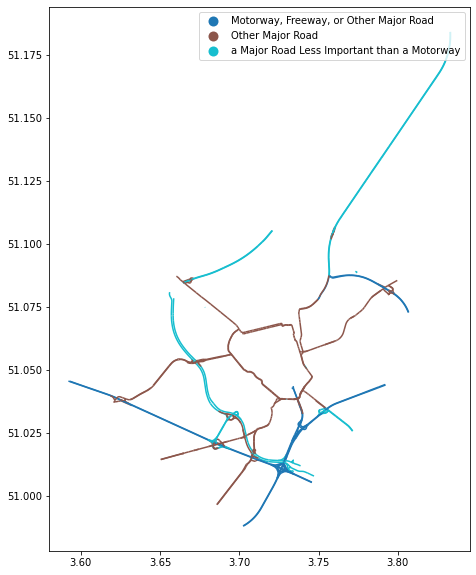

In [193]:
roads_subset.plot(column="frc_omschrijving", figsize=(10, 10), legend=True)

<div class="alert alert-success">

**EXERCISE**:

Before we convert the vector data to a raster, we want to buffer the roads. We will use a larger buffer radius for the larger roads.

* Using the defined `buffer_per_roadtype` dictionary, create a new Series by replacing the values in the "frc_omschrijving" column with the matching buffer radius.
* Convert the `roads_subset` GeoDataFrame to CRS `EPSG:31370`, and create buffered lines (polygons) with the calculated buffer radius distances. Call the result `roads_buffer`.
    
<details><summary>Hints</summary>

* Use the `replace` method to replace the data using the provided mapping `buffer_per_roadtype`.
* The conversion to EPSG:31370 is important to be able to work with the meters to define the buffer size.
* The `buffer` method can take a single value to apply to all values, but also a Series of values, with a buffer size defined for each element.

</details>   
    
</div>

In [199]:
buffer_per_roadtype = {
    "Motorway, Freeway, or Other Major Road": 750,
    "a Major Road Less Important than a Motorway": 500,
    "Other Major Road": 150,
}

In [200]:
buffers = roads_subset["frc_omschrijving"].replace(buffer_per_roadtype)
buffers

16       750
36       150
39       750
45       150
64       150
        ... 
14240    150
14242    150
14244    500
14249    150
14262    150
Name: frc_omschrijving, Length: 1001, dtype: int64

<AxesSubplot:>

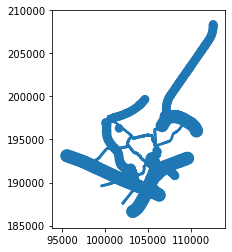

In [201]:
roads_buffer = roads_subset.to_crs("EPSG:31370").buffer(buffers)
roads_buffer.plot()

<div class="alert alert-success">

**EXERCISE**:

Convert the buffered road segments to a raster:
    
* Use `features.features.rasterize()` to convert the `roads_buffer` GeoDataFrame to a raster:
    * Pass the geometry column as the first argument.
    * Pass the shape and transform of the `dem_gent` to specify the desired spatial extent and resolution of the output raster.
* Invert the values of the raster by doing `1 - arr`, and plot the array with `plt.imshow(..)`.
* Recalculate the `suitable_locations` variable, using 1/ land_use_residential, 2/ dem > 10 and 3/ outside the road buffers.  
    
<details><summary>Hints</summary>

* Access the geometry column using the `.geometry` attribute.
* `shape` is also an attribute.
* `.rio.transform()` is a method, so it requires the `()`.
* Previously, suitable locations were `land_use_residential * (dem_gent > 10)`. Combine this with the `(1 - roads_buffer_arr)` output.

</details>   
    
</div>

In [220]:
import rasterio.features

In [221]:
roads_buffer_arr = rasterio.features.rasterize(
    roads_buffer.geometry, 
    out_shape=dem_gent.shape, 
    transform=dem_gent.rio.transform())

In [222]:
1 - roads_buffer_arr

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]], dtype=uint8)

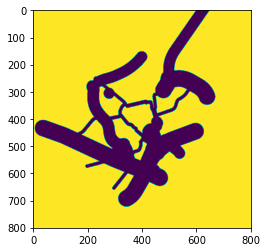

In [223]:
plt.imshow(1 - roads_buffer_arr)

In [224]:
suitable_locations = land_use_residential * (dem_gent > 10) * (1 - roads_buffer_arr)

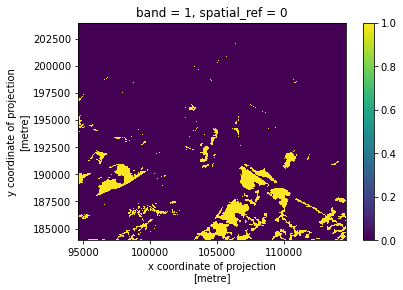

In [225]:
suitable_locations.plot.imshow()

<div class="alert alert-success">

**EXERCISE**:

Make a plot with a background map of the selected locations. 
    
* Plot the provided `gent` GeoDataFrame (a single row table with the are of the Ghent municipality). Use a low "alpha" to give it a light color.
* Add a background map using contextily.
* Plot the `suitable_locations` raster on top of this figure: first mask the array to select only those values larger than zero (so the other values becomes NaN, and are not plotted). Then plot the result, adding it to the existing figure using the `ax` keyword.

<details><summary>Hints</summary>

* The `fig, ax = plt.subplots(figsize=(15, 15))` is a convenient shortcut to prepare a Matplotlib Figure and Axes. 
* Make sure to define the `crs="EPSG:31370"` for contextily.
* `where(...)` is a powerfull way to exclude data as it - by default - adds NaN values for piels where the condition is not True.
</details>   
    
</div>

In [230]:
import contextily

In [236]:
gent = geopandas.read_file("data/gent/vector/gent.geojson")

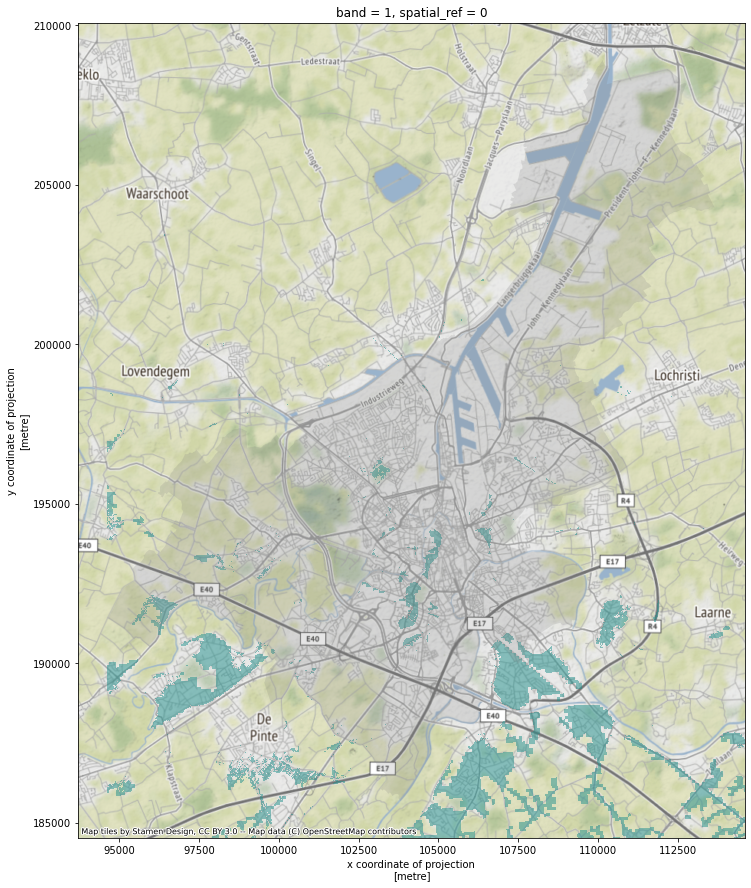

In [237]:
fig, ax = plt.subplots(figsize=(15, 15))

gent.to_crs("EPSG:31370").plot(ax=ax, alpha=0.2, color="grey")
contextily.add_basemap(ax, crs="EPSG:31370")

suitable_locations.where(suitable_locations > 0).plot.imshow(ax=ax, alpha=0.5, add_colorbar=False)
ax.set_aspect("equal")

## Advanced exercises

<div class="alert alert-success">

**EXERCISE**:

We downloaded the data about urban green areas in Ghent (https://data.stad.gent/explore/dataset/parken-gent).

* Read in the data at `data/gent/vector/parken-gent.geojson` into a variable `green`.
* Check the content (first rows, quick plot)
* Convert this vector layer to a raster using the spatial extent and resolution of `dem_gent` as the targer raster.
* The `rasterio.features.rasterize` results in a numpy array. Convert this to a DataArray using the `xr.DataArray(..)` constructor, specifying the coordinates of `dem_gent` (`dem_gent.coords`) for the coordinates of the new array.
    
</div>

In [244]:
green = geopandas.read_file("data/gent/vector/parken-gent.geojson")
green.head()

status                      functies                              globalid  \
0       2  groen met historische waarde  5a5d5be1-16df-4349-96a7-41f2d6bec611   
1       3                        natuur  3320522b-0bfc-4289-a52a-0ee3150ee664   
2       3                        natuur  834f7f14-b65d-4276-a261-df5a0aefa47b   
3       3                   natuur, bos  82a65128-5f5d-489c-9a3e-657810dff29a   
4       3                          None  bcfa5ae0-90f5-408b-bc1d-1758bdd0d42d   

                               naam            urid     statusnaam  gentid  \
0               Tuin Villa Voortman  wel/vecpark445  in uitvoering    None   
1          Volkstuinen Boerse Poort  wel/vecpark455     uitgevoerd    None   
2       Koppelingsgebied Desteldonk  wel/vecpark456     uitgevoerd    None   
3  Koppelingsgebied Doornzele Noord  wel/vecpark459     uitgevoerd    None   
4                  Emile Braunplein  wel/vecpark460     uitgevoerd  GRO227   

   fiche_id  label_id code_jd  \
0       NaN       NaN    None   
1       NaN       NaN    None   
2       NaN       NaN    None   
3       NaN       NaN    None   
4       NaN       NaN    None   

                                            geometry  
0  POLYGON ((3.72144 51.06534, 3.72140 51.06533, ...  
1  POLYGON ((3.68856 51.05741, 3.68834 51.05759, ...  
2  POLYGON ((3.78747 51.12485, 3.78692 51.12490, ...  
3  POLYGON ((3.76543 51.14573, 3.76542 51.14575, ...  
4  MULTIPOLYGON (((3.72413 51.05391, 3.72412 51.0...

<AxesSubplot:>

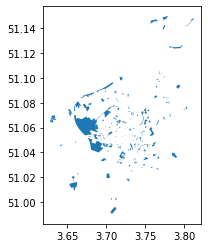

In [245]:
green.plot()

In [246]:
import rasterio.features

green_arr = rasterio.features.rasterize(
    green.to_crs("EPSG:31370").geometry, 
    out_shape=dem_gent.shape, 
    transform=dem_gent.rio.transform())

/home/stijnvh/.pyenv/versions/miniconda3-latest/envs/DS-geospatial/lib/python3.8/site-packages/rasterio/features.py:318: ShapeSkipWarning: Invalid or empty shape None at index 67 will not be rasterized.
  warnings.warn('Invalid or empty shape {} at index {} will not be rasterized.'.format(geom, index), ShapeSkipWarning)
/home/stijnvh/.pyenv/versions/miniconda3-latest/envs/DS-geospatial/lib/python3.8/site-packages/rasterio/features.py:318: ShapeSkipWarning: Invalid or empty shape None at index 83 will not be rasterized.
  warnings.warn('Invalid or empty shape {} at index {} will not be rasterized.'.format(geom, index), ShapeSkipWarning)
/home/stijnvh/.pyenv/versions/miniconda3-latest/envs/DS-geospatial/lib/python3.8/site-packages/rasterio/features.py:318: ShapeSkipWarning: Invalid or empty shape None at index 157 will not be rasterized.
  warnings.warn('Invalid or empty shape {} at index {} will not be rasterized.'.format(geom, index), ShapeSkipWarning)


In [247]:
green_arr = xr.DataArray(green_arr, coords=dem_gent.coords)

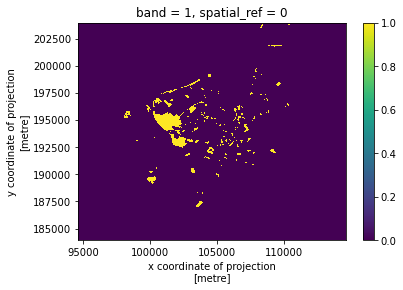

In [248]:
green_arr.plot.imshow()

<div class="alert alert-success">

**EXERCISE**:

For the urban green areas, we want to calculate a statistic for a neighbourhood around each pixel ("focal" statistics). This can be expressed as a convolution with a defined kernel.    

The [xarray-spatial](https://xarray-spatial.org/index.html) package includes functionality for such focal statistics and convolutions.

* Use the `focal.focal_stats()` function from xarray-spatial to calculate the sum of green are in a neighborhood of 500m around each point. Check the help of this function to see which arguments to specify.
* Make a plot of the resulting `green_area` array.
    
</div>

In [249]:
from xrspatial import focal, convolution

In [250]:
x, y = convolution.calc_cellsize(green_arr)

In [251]:
kernel = convolution.circle_kernel(x, y, 500)

In [252]:
%%time
green_area = focal.focal_stats(green_arr, kernel, stats_funcs=["sum"])

CPU times: user 4.52 s, sys: 20.9 ms, total: 4.55 s
Wall time: 4.55 s


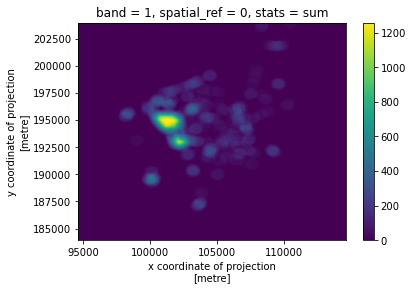

In [253]:
green_area.sel(stats="sum").plot.imshow()

The `scipy` package also provides optimized convolution algorithms. In case of the "sum" statistic, this is equivalent:

In [254]:
from scipy import signal

In [255]:
%%time
green_area_arr = signal.convolve(green_arr, kernel, mode='same')

CPU times: user 27.8 ms, sys: 7.89 ms, total: 35.7 ms
Wall time: 34.9 ms


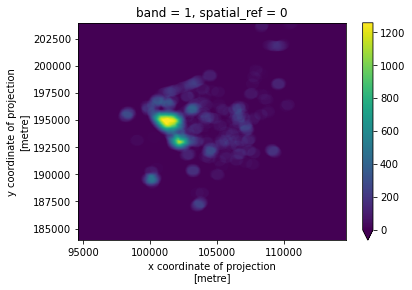

In [256]:
xr.DataArray(green_area_arr, coords=dem_gent.coords).plot.imshow(vmin=0)

<div class="alert alert-success">

**EXERCISE**:

Make a plot with a background map of the selected locations, i.e. land_use_residential, dem > 10, outside road buffers and 'sufficient'as green area. 
    
Define sufficient green area as the `green_area` pixels where the sum of the convolution (previous exercise) is larger as 10 (keep those values and convert pixels with values lower than 10 to 0 values). Multiply the different conditions/categories, so the green area score is included in the final result.
    
</div>

In [264]:
green_area10 = green_area.sel(stats="sum").where(green_area.sel(stats="sum") > 10, 0)

In [265]:
suitable_locations = land_use_residential * (dem_gent > 10) * (1 - roads_buffer_arr) * green_area10

In [266]:
import contextily

In [267]:
gent = geopandas.read_file("data/gent/vector/gent.geojson")

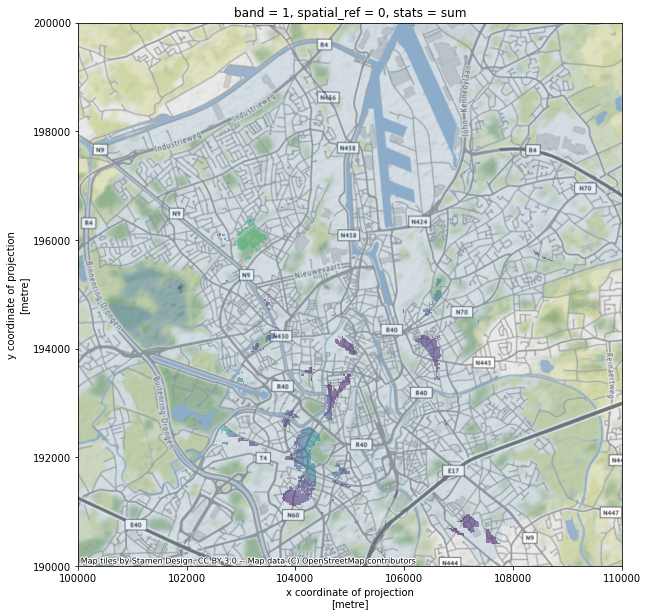

In [268]:
fig, ax = plt.subplots(figsize=(10, 10))
gent.to_crs("EPSG:31370").plot(ax=ax, alpha=0.1)
ax.set(ylim=(190_000, 200_000), xlim=(100_000, 110_000))
contextily.add_basemap(ax, crs="EPSG:31370")

suitable_locations.where(suitable_locations>0).plot.imshow(ax=ax, alpha=0.5, add_colorbar=False)
ax.set_aspect("equal")

# Extracting values from rasters based on vector data

The **rasterstats** package provides methods to calculate summary statistics of geospatial raster datasets based on vector geometries (https://github.com/perrygeo/python-rasterstats)

To illustrate this, we are reading a raster file with elevation data of the full world (the file contains a single band for the elevation, save the file in the `data` subdirectory; [download link](https://www.eea.europa.eu/data-and-maps/data/world-digital-elevation-model-etopo5/zipped-dem-geotiff-raster-geographic-tag-image-file-format-raster-data/zipped-dem-geotiff-raster-geographic-tag-image-file-format-raster-data/at_download/file)):

In [276]:
countries = geopandas.read_file("./data/ne_110m_admin_0_countries.zip")
cities = geopandas.read_file("./data/ne_110m_populated_places.zip")

In [281]:
dem_geotiff = "data/dem_geotiff/DEM_geotiff/alwdgg.tif"

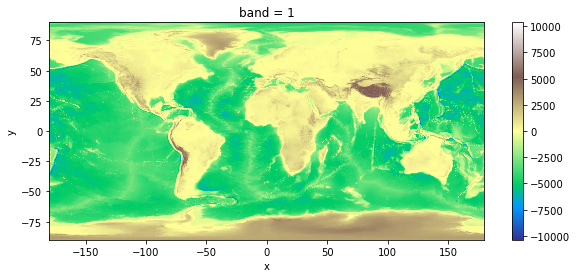

In [282]:
img = xr.open_rasterio(dem_geotiff).sel(band=1).plot.imshow(cmap="terrain", figsize=(10, 4), )
img.axes.set_aspect("equal")

Given this raster of the elevation, we might want to know the elevation at a certain location or for each country.
For the countries example, we want to extract the pixel values that fall within a country polygon, and calculate a statistic for it, such as the mean or the maximum.

Such functionality to extract information from a raster for given vector data is provided by the rasterstats package.

In [283]:
import rasterstats

For extracting the pixel values for polygons, we use the `zonal_stats` function, passing it the GeoSeries, the path to the raster file, and the method to compute the statistics.

In [288]:
result = rasterstats.zonal_stats(countries.geometry, dem_geotiff,
                                 stats=['min', 'mean', 'max'], 
                                 nodata=-999)

The results can be assigned to new columns:

In [289]:
countries[['min', 'max', 'mean']] = pd.DataFrame(result)

In [290]:
countries.head()

iso_a3                  name      continent     pop_est  gdp_md_est  \
0    AFG           Afghanistan           Asia  34124811.0     64080.0   
1    AGO                Angola         Africa  29310273.0    189000.0   
2    ALB               Albania         Europe   3047987.0     33900.0   
3    ARE  United Arab Emirates           Asia   6072475.0    667200.0   
4    ARG             Argentina  South America  44293293.0    879400.0   

                                            geometry     min     max  \
0  POLYGON ((61.21082 35.65007, 62.23065 35.27066...   244.0  5699.0   
1  MULTIPOLYGON (((23.90415 -11.72228, 24.07991 -... -1002.0  2103.0   
2  POLYGON ((21.02004 40.84273, 20.99999 40.58000...  -250.0  2138.0   
3  POLYGON ((51.57952 24.24550, 51.75744 24.29407...   -44.0  1524.0   
4  MULTIPOLYGON (((-66.95992 -54.89681, -67.56244...  -945.0  5181.0   

          mean  
0  1865.941620  
1  1070.461868  
2   731.139738  
3   115.114370  
4   655.130176

And then we can sort by the average elevation of the country:

In [291]:
countries.sort_values('mean', ascending=False).head()

iso_a3        name   continent     pop_est  gdp_md_est  \
157    TJK  Tajikistan        Asia   8468555.0     25810.0   
85     KGZ  Kyrgyzstan        Asia   5789122.0     21010.0   
24     BTN      Bhutan        Asia    758288.0      6432.0   
119    NPL       Nepal        Asia  29384297.0     71520.0   
6      ATA  Antarctica  Antarctica      4050.0       810.0   

                                              geometry     min     max  \
157  POLYGON ((74.980 37.420, 73.949 37.422, 73.260...   335.0  6096.0   
85   POLYGON ((80.260 42.350, 80.119 42.124, 78.544...   610.0  5791.0   
24   POLYGON ((91.697 27.772, 92.104 27.453, 92.033...   305.0  5486.0   
119  POLYGON ((81.111 30.183, 81.526 30.423, 82.328...    61.0  6705.0   
6    MULTIPOLYGON (((-59.572 -80.040, -59.866 -80.5... -1970.0  4115.0   

            mean  
157  3103.231105  
85   2867.717142  
24   2573.559846  
119  2408.907816  
6    2374.075028

For points, a similar function called `point_query` can be used (specifying the interpolation method):

In [292]:
cities["elevation"] = rasterstats.point_query(cities.geometry, 
                                              dem_geotiff, interpolate='bilinear',
                                              nodata=-999)

In [293]:
cities.sort_values(by="elevation", ascending=False).head()

name                     geometry    elevation
122   La Paz  POINT (-68.15193 -16.49603)  4378.784708
126  Thimphu    POINT (89.63901 27.47299)  3554.551761
114    Sucre  POINT (-65.25952 -19.04097)  3116.501683
88     Quito   POINT (-78.50200 -0.21304)  2748.044039
211    Kabul    POINT (69.18131 34.51864)  2588.508886

-----------

# A bit more about WFS

> The Web Feature Service (WFS) represents a change in the way geographic information is created, modified and exchanged on the Internet. Rather than sharing geographic information at the file level using File Transfer Protocol (FTP), for example, the WFS offers direct fine-grained...

(https://www.ogc.org/standards/wfs)

In brief, the WFS is the specification to __access and download vector datasets__.

To access WFS data, you need the following information:
- URL of the service, e.g. `https://geoservices.informatievlaanderen.be/overdrachtdiensten/VHAWaterlopen/wfs`. Looking for these URLS, check [WFS page of Michel Stuyts](https://wfs.michelstuyts.be/?lang=en)
- The available projections and layers, also check [WFS page of Michel Stuyts](https://wfs.michelstuyts.be/?lang=en) or start looking into the `GetCapabilities`, e.g. [vha waterlopen](https://geoservices.informatievlaanderen.be/overdrachtdiensten/VHAWaterlopen/wfs?REQUEST=GetCapabilities&SERVICE=WFS)

Instead of downloading the entire data set, filtering the request itself (only downloading what you need) is a good idea, using the `cql_filter` filter. Finding out these is sometimes a bit of hazzle... E.g. quickly [preview the data in QGIS](https://docs.qgis.org/3.10/en/docs/training_manual/online_resources/wfs.html?highlight=wfs).

You can also use the [`OWSLib` library](https://geopython.github.io/OWSLib/#wfs). But as WFS is a webservice, the `requests` package will be sufficient for simple queries.

As an example - municipalities in Belgium, see https://wfs.michelstuyts.be/service.php?id=140&lang=en, _WFS Voorlopig referentiebestand gemeentegrenzen 2019_

- URL of the service: https://geoservices.informatievlaanderen.be/overdrachtdiensten/VRBG2019/wfs
- Available projections:  EPSG:4258, EPSG:3812,...
- Available layers: VRBG2019:Refgem:,  VRBG2019:Refarr:,...
- Column `Naam` contains the municipatility, e.g. `Gent`

<AxesSubplot:>

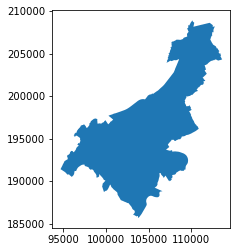

In [294]:
wfs_municipality = "https://geoservices.informatievlaanderen.be/overdrachtdiensten/VRBG2019/wfs"
params = dict(service='WFS', version='1.1.0', request='GetFeature',
              typeName='VRBG2019:Refgem', outputFormat='json',
              cql_filter="NAAM='Gent'", srs="31370")

# Fetch data from WFS using requests
r = requests.get(wfs_municipality, params=params)
gent = geopandas.GeoDataFrame.from_features(json.loads(r.content), crs="epsg:31370")
gent.plot()

# Cloud: only download what you need

Rasterio/rioxarray only reads the data from disk that is requested to overcome loading entire data sets into memory. The same applies to downloading data, overcoming entire downloads when only a fraction is required (when the online resource supports this). An example is https://zenodo.org/record/2654620, which is available as [Cloud Optimized Geotiff (COG)](https://www.cogeo.org/). Also cloud providers (AWS, google,...) do support COG files, e.g. [Landstat images](https://docs.opendata.aws/landsat-pds/readme.html).

These files are typically very large to download, whereas we might only need a small subset of the data. COG files support downloading a subset of the data you need using a masking approach.

Let's use the Averbode nature reserve data as an example, available at the URL: http://s3-eu-west-1.amazonaws.com/lw-remote-sensing/cogeo/20160401_ABH_1_Ortho.tif

In [295]:
averbode_cog_rgb = 'http://s3-eu-west-1.amazonaws.com/lw-remote-sensing/cogeo/20160401_ABH_1_Ortho.tif'

Check the metadata, without downloading the data itself:

In [296]:
averbode_data = rioxarray.open_rasterio(averbode_cog_rgb)

In [297]:
averbode_data

<xarray.DataArray (band: 4, y: 35405, x: 37645)>
[5331284900 values with dtype=uint8]
Coordinates:
  * band         (band) int64 1 2 3 4
  * x            (x) float64 1.908e+05 1.908e+05 ... 1.923e+05 1.923e+05
  * y            (y) float64 1.924e+05 1.924e+05 1.924e+05 ... 1.91e+05 1.91e+05
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0
    units:         ('metre', 'metre', 'metre', 'metre')

Downloading the entire data set would be 37645*35405\*4 pixels of 1 byte, so more or less 5.3 GByte

In [298]:
37645*35405*4 / 1e9  # Gb

5.3312849

In [299]:
averbode_data.size / 1e9  # Gb

5.3312849

Assume that we have a study area which is much smaller than the total extent of the available image:

In [300]:
left, bottom, right, top = averbode_data.rio.bounds()

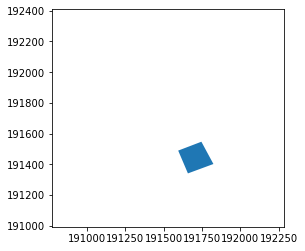

In [301]:
averbode_study_area = geopandas.read_file("./data/averbode/study_area.geojson")
ax = averbode_study_area.plot();
ax.set_xlim(left, right);
ax.set_ylim(bottom, top);

In the case of COG data, the data can sometimes be requested on different resolution levels when stored as such. So, to get a very broad overview of the data, we can request the coarsest resolution by resampling and download the data at the resampled resolution:

In [302]:
with rasterio.open(averbode_cog_rgb) as src:
    # check available overviews for band 1
    print(f"Available resolutions are {src.overviews(1)}")

Available resolutions are [2, 4, 8, 16, 32, 64, 128, 254]


In [303]:
averbode_64 = rioxarray.open_rasterio(averbode_cog_rgb, overview_level=5)

In [304]:
averbode_64.size / 1e6  # Mb

1.305224

In [305]:
averbode_64.rio.resolution()

(2.5564746313247313, -2.556255823604303)

Compare the thumbnail version of the data with our study area:

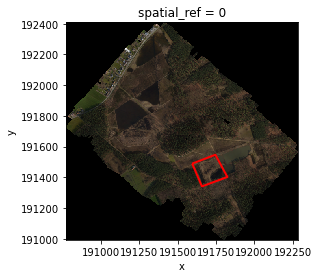

In [306]:
fig, ax = plt.subplots()
averbode_64.sel(band=[1, 2, 3]).plot.imshow(ax=ax)
averbode_study_area.plot(ax=ax, color='None', edgecolor='red', linewidth=2);

Downloading the entire data file would be overkill. Instead, we only want to download the data of the study area. This can be done with the `clip()` method using the `from_disk` option. 
The resulting data set will still be around 100MB and will take a bit of time to download, but this is only a fraction of the original data file:

In [307]:
%%time
# Only run this cell when sufficient band width ;-)
averbode_subset = averbode_data.rio.clip(averbode_study_area.geometry, from_disk=True)

CPU times: user 2.56 s, sys: 1.49 s, total: 4.05 s
Wall time: 58.1 s


In [308]:
averbode_subset.size / 1e6  # Mb

118.258016

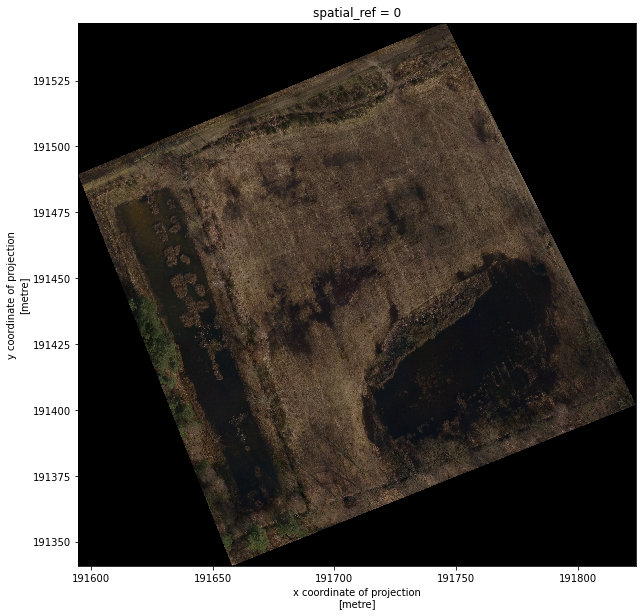

In [309]:
averbode_subset.sel(band=[1, 2, 3]).plot.imshow(figsize=(10, 10))

The rasterio way:

```python
output_file = "./averbode_orthophoto.tiff"

# Only run this cell when sufficient band width ;-)
with rasterio.open(averbode_cog_rgb) as averbode_rgb:
    averbode_rgb_image, averbode_rgb_transform = rasterio.mask.mask(averbode_rgb, averbode_study_area.geometry, crop=True)
    averbode_rgb_profile = averbode_rgb.profile  

    averbode_rgb_profile.update({"driver": "GTiff",
                                 "height": averbode_rgb_image.shape[1],
                                 "width": averbode_rgb_image.shape[2],
                                 "transform": averbode_rgb_transform
                                })
    
    with rasterio.open(output_file, "w", **averbode_rgb_profile) as dest:
        dest.write(averbode_rgb_image)
```

Thanks to https://geohackweek.github.io/raster/04-workingwithrasters/ for the inspiration